In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv
/kaggle/input/snips-dataset/train_data.csv
/kaggle/input/snips-dataset/validate_data.csv


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import timeit
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Путь к файлу CSV
data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv"
train_data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv"
test_data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv"

# Чтение данных из CSV-файлов
data = pd.read_csv(data_path)
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

data = data.rename(columns={'atis_flight': 'intent', ' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning': 'text'})
lost_intent = {'intent': 'atis_flight', 'text': 'i want to fly from boston at 838 am and arrive in denver at 1110 in the morning'}
data = pd.concat([data, pd.DataFrame([lost_intent])], ignore_index=True)

# Find classes with only one sample
class_counts = data['intent'].value_counts()
single_sample_classes = class_counts[class_counts == 1].index.tolist()

# Separate single sample classes
single_sample_data = data[data['intent'].isin(single_sample_classes)]
multiple_sample_data = data[~data['intent'].isin(single_sample_classes)]

# train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['intent'])
# Perform stratified split on multiple sample data
train_multiple, test_multiple = train_test_split(multiple_sample_data, test_size=0.2, random_state=42, stratify=multiple_sample_data['intent'])

# Add single sample data to both train and test sets to ensure all classes are present
train = pd.concat([train_multiple, single_sample_data]).reset_index(drop=True)
test = pd.concat([test_multiple, single_sample_data]).reset_index(drop=True)

# Ensure no duplicates in train and test sets
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

unique_values_normalized = train['intent'].value_counts(normalize=True)
unique_values_normalized_test = test['intent'].value_counts(normalize=True)
print(unique_values_normalized*100, len(unique_values_normalized), len(unique_values_normalized_test))

# Check for missing classes and ensure all classes are present
train_classes = set(train['intent'])
test_classes = set(test['intent'])
all_classes = set(data['intent'])

# Find missing classes in train and test sets
missing_train_classes = all_classes - train_classes
missing_test_classes = all_classes - test_classes

# Add missing classes examples to train and test sets
if missing_train_classes:
    missing_train_data = data[data['intent'].isin(missing_train_classes)]
    train = pd.concat([train, missing_train_data])
    train = train.drop_duplicates().reset_index(drop=True)

if missing_test_classes:
    missing_test_data = data[data['intent'].isin(missing_test_classes)]
    test = pd.concat([test, missing_test_data])
    test = test.drop_duplicates().reset_index(drop=True)

# Print unique value proportions
unique_values_normalized = train['intent'].value_counts(normalize=True)
unique_values_normalized_test = test['intent'].value_counts(normalize=True)
print(unique_values_normalized * 100, len(unique_values_normalized), len(unique_values_normalized_test)) 

intent
atis_flight                                 73.869079
atis_airfare                                 8.621607
atis_ground_service                          5.082491
atis_airline                                 3.113358
atis_abbreviation                            2.474721
atis_aircraft                                1.676424
atis_flight_time                             1.117616
atis_quantity                                1.091006
atis_distance                                0.425758
atis_flight#atis_airfare                     0.399148
atis_ground_fare                             0.372539
atis_airport                                 0.372539
atis_city                                    0.372539
atis_capacity                                0.345929
atis_flight_no                               0.266099
atis_meal                                    0.133049
atis_restriction                             0.106440
atis_airline#atis_flight_no                  0.053220
atis_ground_service#a

In [5]:
# # Путь к файлу CSV
# train_data_path = "/kaggle/input/snips-dataset/train_data.csv"
# validate_data_path = "/kaggle/input/snips-dataset/validate_data.csv"

# # Чтение данных из CSV-файлов
# train_data = pd.read_csv(train_data_path)
# validate_data = pd.read_csv(validate_data_path)

# # Вывод первых 5 строк каждого DataFrame
# print("Train data:")
# print(train_data.head())
# print("\nValidate data:")
# print(validate_data.head())

In [6]:
# unique_values_normalized = train_data['intent'].value_counts(normalize=True)
# print(unique_values_normalized)

In [7]:
# train_data = train_data.drop('entity', axis=1)
# validate_data = validate_data.drop('entity', axis=1)

In [8]:
# # Удалите строки, где столбец 'column_name' пуст
# train_data = train_data.dropna(subset=['text'])
# validate_data = validate_data.dropna(subset=['text'])

In [9]:
# # Подсчитываем количество примеров для каждого класса
# class_counts = train_data['intent'].value_counts()

# # Находим класс с наименьшим количеством примеров
# min_class = class_counts.idxmin()
# min_class_count = class_counts.min()

# # Делаем undersampling для всех остальных классов
# balanced_data = train_data[train_data['intent'] == min_class]
# for intent in class_counts.index:
#     if intent != min_class:
#         samples = train_data[train_data['intent'] == intent].sample(min_class_count)
#         balanced_data = pd.concat([balanced_data, samples], axis=0)

# # Теперь в balanced_data примеры каждого класса представлены в одинаковом количестве

In [10]:
# balanced_data = train_data

In [11]:
# balanced_data.info()

In [12]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [13]:
from torch.nn import CrossEntropyLoss

In [14]:
class IntentClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [15]:
class EarlyStopping:
    def __init__(self, patience=2, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


In [16]:
from torch import nn
from transformers import DistilBertModel

class CustomDistilBertModel(nn.Module):
    def __init__(self, num_labels):
        super(CustomDistilBertModel, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, num_labels)

    def forward(self, input_ids, attention_mask):
        output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output[0][:, 0]
        output = self.dropout(pooled_output)
        output = self.fc1(output)
        output = nn.Tanh()(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output



In [17]:
# Преобразование меток в числовой формат
unique_intents = train['intent'].unique().tolist()
intent_mapping = {intent: i for i, intent in enumerate(unique_intents)}
train_labels = [intent_mapping[intent] for intent in train['intent']]
test_labels = [intent_mapping[intent] for intent in test['intent']]

In [18]:
# Создание наборов данных PyTorch
max_len = 128
batch_size = 16 #16
train_dataset = IntentClassificationDataset(train['text'].tolist(), train_labels, tokenizer, max_len)
test_dataset = IntentClassificationDataset(test['text'].tolist(), test_labels, tokenizer, max_len)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [19]:
from transformers import DistilBertForSequenceClassification, AdamW
import torch

# Загрузка модели DistilBERT
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(unique_intents))
model = CustomDistilBertModel(num_labels=len(unique_intents))

# Компиляция модели
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
# Создание экземпляра класса EarlyStopping
early_stopping = EarlyStopping(patience=5, verbose=True)

In [21]:
# # Замораживаем все параметры модели
# for param in model.parameters():
#     param.requires_grad = False

# # Размораживаем параметры последнего слоя
# for param in model.classifier.parameters():
#     param.requires_grad = True


In [22]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt
# from torch.nn import CrossEntropyLoss

Epoch 1: 100%|██████████| 235/235 [00:23<00:00,  9.80it/s]


Epoch: 1, Train Loss: 0.4692


Validation Epoch 1: 100%|██████████| 62/62 [00:02<00:00, 24.65it/s]


Average validation loss:  0.2271037449639651
Validation loss decreased (inf --> 0.227104).  Saving model ...


Epoch 2: 100%|██████████| 235/235 [00:23<00:00, 10.15it/s]


Epoch: 2, Train Loss: 0.1030


Validation Epoch 2: 100%|██████████| 62/62 [00:02<00:00, 24.88it/s]


Average validation loss:  0.17735794873818034
Validation loss decreased (0.227104 --> 0.177358).  Saving model ...


Epoch 3: 100%|██████████| 235/235 [00:23<00:00, 10.14it/s]


Epoch: 3, Train Loss: 0.0613


Validation Epoch 3: 100%|██████████| 62/62 [00:02<00:00, 24.82it/s]


Average validation loss:  0.2035630820957463
EarlyStopping counter: 1 out of 5


Epoch 4: 100%|██████████| 235/235 [00:23<00:00, 10.14it/s]


Epoch: 4, Train Loss: 0.0501


Validation Epoch 4: 100%|██████████| 62/62 [00:02<00:00, 24.90it/s]


Average validation loss:  0.1318548694910151
Validation loss decreased (0.177358 --> 0.131855).  Saving model ...


Epoch 5: 100%|██████████| 235/235 [00:23<00:00, 10.17it/s]


Epoch: 5, Train Loss: 0.0331


Validation Epoch 5: 100%|██████████| 62/62 [00:02<00:00, 25.03it/s]


Average validation loss:  0.12942151763596602
Validation loss decreased (0.131855 --> 0.129422).  Saving model ...


Epoch 6: 100%|██████████| 235/235 [00:23<00:00, 10.17it/s]


Epoch: 6, Train Loss: 0.0393


Validation Epoch 6: 100%|██████████| 62/62 [00:02<00:00, 24.99it/s]


Average validation loss:  0.13216525671868434
EarlyStopping counter: 1 out of 5


Epoch 7: 100%|██████████| 235/235 [00:23<00:00, 10.16it/s]


Epoch: 7, Train Loss: 0.0227


Validation Epoch 7: 100%|██████████| 62/62 [00:02<00:00, 24.95it/s]


Average validation loss:  0.10968787035146248
Validation loss decreased (0.129422 --> 0.109688).  Saving model ...


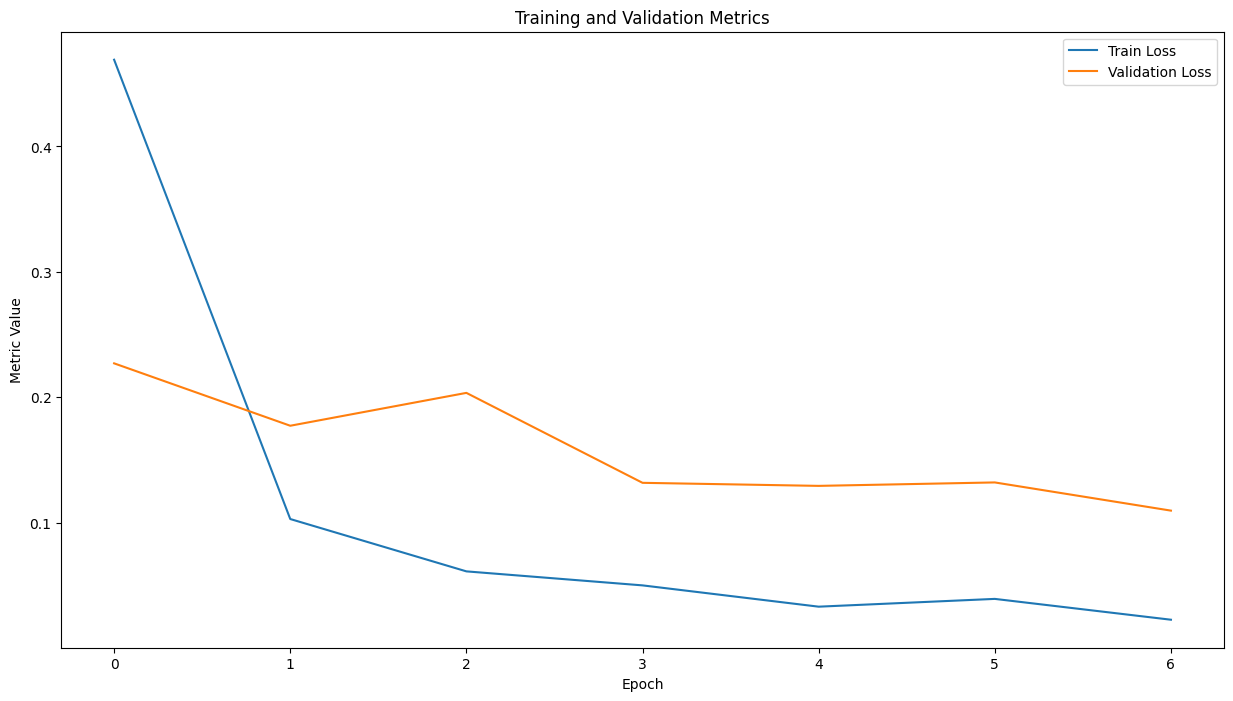

In [23]:
# Количество эпох
epochs = 7

# Списки для хранения значений потерь и метрик на каждой эпохе
loss_values = []
val_loss_values = []  # список для потерь валидации
acc_values = []
rec_values = []
f1_values = []


for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Вызов модели без аргумента labels
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Вычисление потерь
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(outputs.view(-1, len(unique_intents)), labels.view(-1))
        
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_data_loader)
    loss_values.append(avg_train_loss)

    print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}")

    model.eval()
    val_loss = 0
    predictions , true_labels = [], []

    for batch in tqdm(test_data_loader, desc=f"Validation Epoch {epoch+1}"):
        with torch.no_grad():
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Вызов модели без аргумента labels
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Вычисление потерь
            loss = loss_fct(outputs.view(-1, len(unique_intents)), labels.view(-1))
            
            val_loss += loss.item()

            logits = outputs.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            
            predictions.extend(np.argmax(logits, axis=1).flatten())
            true_labels.extend(label_ids.flatten())

    
    avg_val_loss = val_loss / len(test_data_loader)
    val_loss_values.append(avg_val_loss)  # сохраняем потери валидации
    print('Average validation loss: ', avg_val_loss)

    early_stopping(avg_val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Построение графиков потерь и метрик
plt.figure(figsize=(15,8))
plt.title("Training and Validation Metrics")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")

plt.plot(loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')  # добавляем потери валидации на график
plt.legend()
plt.show()


In [24]:
# new
# from transformers import BertForSequenceClassification
# import matplotlib.pyplot as plt

# # tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
# # model = BertForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2")

# # Количество эпох
# epochs = 50

# # Список для хранения значений потерь на каждой эпохе
# loss_values = []

# for epoch in range(epochs):
#     model.train()
#     total_loss = 0

#     for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}"):
#         optimizer.zero_grad()
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["labels"].to(device)

#         # Вызов модели без аргумента labels
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
#         # Вычисление потерь
#         loss_fct = CrossEntropyLoss()
#         loss = loss_fct(outputs.view(-1, len(unique_intents)), labels.view(-1))
        
#         total_loss += loss.item()
#         loss.backward()
#         optimizer.step()

#     avg_train_loss = total_loss / len(train_data_loader)
#     loss_values.append(avg_train_loss)

#     print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}")

#     model.eval()
#     val_loss = 0
#     predictions , true_labels = [], []

#     for batch in tqdm(test_data_loader, desc=f"Validation Epoch {epoch+1}"):
#         with torch.no_grad():
#             input_ids = batch["input_ids"].to(device)
#             attention_mask = batch["attention_mask"].to(device)
#             labels = batch["labels"].to(device)

#             # Вызов модели без аргумента labels
#             outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
#             # Вычисление потерь
#             loss = loss_fct(outputs.view(-1, len(unique_intents)), labels.view(-1))
            
#             val_loss += loss.item()

#     avg_val_loss = val_loss / len(test_data_loader)
#     print('Average validation loss: ', avg_val_loss)

#     early_stopping(avg_val_loss, model)

#     if early_stopping.early_stop:
#         print("Early stopping")
#         break

# # Построение графика потерь
# plt.figure(figsize=(15,8))
# plt.title("Training loss")
# plt.xlabel("Batch")
# plt.ylabel("Loss")
# plt.plot(loss_values)
# plt.show()

In [25]:
# old working

# # Обучение модели
# for epoch in range(50):
#     model.train()
#     total_loss = 0
#     progress_bar = tqdm(train_data_loader, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
#     for batch in progress_bar:
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["labels"].to(device)

#         # Вызов модели
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
#         # Вычисление потерь
#         loss_fct = CrossEntropyLoss()
#         loss = loss_fct(outputs.view(-1, len(unique_intents)), labels.view(-1))
        
#         total_loss += loss.item()

#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         # Обновление шкалы выполнения
#         progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

#     # Расчет среднего значения потерь за эпоху
#     avg_train_loss = total_loss / len(train_data_loader)
#     print('Average training loss: ', avg_train_loss)

#     # Валидация на независимом наборе данных
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for batch in test_data_loader:
#             input_ids = batch["input_ids"].to(device)
#             attention_mask = batch["attention_mask"].to(device)
#             labels = batch["labels"].to(device)

#             # Вызов модели
#             outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
#             # Вычисление потерь
#             loss = loss_fct(outputs.view(-1, len(unique_intents)), labels.view(-1))
            
#             val_loss += loss.item()

#     avg_val_loss = val_loss / len(test_data_loader)
#     print('Average validation loss: ', avg_val_loss)

#     early_stopping(avg_val_loss, model)

#     if early_stopping.early_stop:
#         print("Early stopping")
#         break

In [26]:
# Предсказание на тестовых данных
model.eval()
predictions = []
start_test = timeit.default_timer()
with torch.no_grad():
    for batch in test_data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

        predictions.extend(preds)
end_test = timeit.default_timer()

predicted_labels = [pred.item() for pred in predictions]

# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')
print(balanced_accuracy_score(test_labels, predicted_labels))
print(precision_recall_fscore_support(test_labels, predicted_labels, average='weighted'))

Time for testing: 1.7497 seconds
Average time per response: 0.001785 seconds
0.8180601090773095
(0.9829048822326132, 0.9836734693877551, 0.9823396795808685, None)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# Построение confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
#print(f'Confusion Matrix: \n{cm}')

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

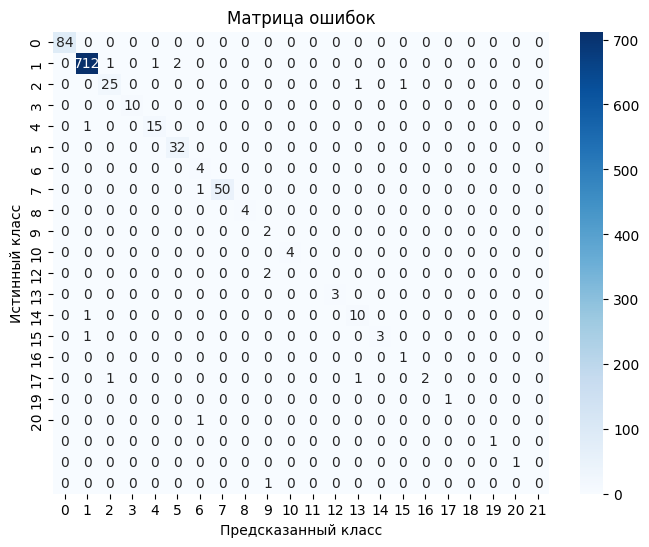

In [29]:
# Визуализация матрицы ошибок с использованием seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(test_labels), yticklabels=set(predicted_labels))
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()
